In [3]:
"""
Multichannel (non-rgb) BM3D denoising demo file, based on
Y. Mäkinen, L. Azzari, A. Foi, 2020,
"Collaborative Filtering of Correlated Noise: Exact Transform-Domain Variance for Improved Shrinkage and Patch Matching",
in IEEE Transactions on Image Processing, vol. 29, pp. 8339-8354.
For multichannel images, block matching is performed only on the first channel.
"""


import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from bm3d import bm3d, BM3DProfile, bm3d_rgb
from experiment_funcs import get_experiment_noise, get_psnr, get_cropped_psnr
from scipy.io import loadmat

from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.signal import fftconvolve
from bm3d import gaussian_kernel

In [4]:
def get_experiment_kernel(noise_type: str, noise_var: float, sz: tuple = np.array((101, 101))):
    """
    Get kernel for generating noise from specific experiment from the paper.
    :param noise_type: Noise type string, g[0-4](w|)
    :param noise_var: noise variance
    :param sz: size of image, used only for g4 and g4w
    :return: experiment kernel with the l2-norm equal to variance
    """
    # if noiseType == gw / g0
    kernel = np.array([[1]])
    noise_types = ['gw', 'g0', 'g1', 'g2', 'g3', 'g4', 'g1w', 'g2w', 'g3w', 'g4w']
    if noise_type not in noise_types:
        raise ValueError("Noise type must be one of " + str(noise_types))

    if noise_type != "g4" and noise_type != "g4w":
        # Crop this size of kernel when generating,
        # unless pink noise, in which
        # if noiseType == we want to use the full image size
        sz = np.array([101, 101])
    else:
        sz = np.array(sz)

    # Sizes for meshgrids
    sz2 = -(1 - (sz % 2)) * 1 + np.floor(sz / 2)
    sz1 = np.floor(sz / 2)
    uu, vv = np.meshgrid([i for i in range(-int(sz1[0]), int(sz2[0]) + 1)],
                         [i for i in range(-int(sz1[1]), int(sz2[1]) + 1)])

    beta = 0.8

    if noise_type[0:2] == 'g1':
        # Horizontal line
        kernel = np.atleast_2d(16 - abs(np.linspace(1, 31, 31) - 16))

    elif noise_type[0:2] == 'g2':
        # Circular repeating pattern
        scale = 1
        dist = uu ** 2 + vv ** 2
        kernel = np.cos(np.sqrt(dist) / scale) * gaussian_kernel((sz[0], sz[1]), 10)

    elif noise_type[0:2] == 'g3':
        # Diagonal line pattern kernel
        scale = 1
        kernel = np.cos((uu + vv) / scale) * gaussian_kernel((sz[0], sz[1]), 10)

    elif noise_type[0:2] == 'g4':
        # Pink noise
        dist = uu ** 2 + vv ** 2
        n = sz[0] * sz[1]
        spec = (np.sqrt((np.sqrt(n) * 1e-2) / (np.sqrt(dist) + np.sqrt(n) * 1e-2)))
        kernel = fftshift(ifft2(ifftshift(spec)))

    else:  # gw and g0 are white
        beta = 0

    # -- Noise with additional white component --

    if len(noise_type) > 2 and noise_type[2] == 'w':
        kernel = kernel / np.sqrt(np.sum(kernel ** 2))
        kalpha = np.sqrt((1 - beta) + beta * abs(fft2(kernel, (sz[0], sz[1]))) ** 2)
        kernel = fftshift(ifft2(kalpha))

    kernel = np.real(kernel)
    # Correct variance
    kernel = kernel / np.sqrt(np.sum(kernel ** 2)) * np.sqrt(noise_var)

    return kernel

In [5]:
def get_experiment_noise(noise_type: str, noise_var: float, realization: int, sz: tuple):
    """
    Generate noise for experiment with specified kernel, variance, seed and size.
    Return noise and relevant parameters.
    The generated noise is non-circular.
    :param noise_type: Noise type, see get_experiment_kernel for list of accepted types.
    :param noise_var: Noise variance of the resulting noise
    :param realization: Seed for the noise realization
    :param sz: image size -> size of resulting noise
    :return: noise, PSD, and kernel
    """
    np.random.seed(realization)

    # Get pre-specified kernel
    kernel = get_experiment_kernel(noise_type, noise_var, sz)

    # Create noisy image
    half_kernel = np.ceil(np.array(kernel.shape) / 2)

    if len(sz) == 3 and half_kernel.size == 2:
        half_kernel = [half_kernel[0], half_kernel[1], 0]
        kernel = np.atleast_3d(kernel)

    half_kernel = np.array(half_kernel, dtype=int)

    # Crop edges
    noise = fftconvolve(np.random.normal(size=(sz + 2 * half_kernel)), kernel, mode='same')
    noise = np.atleast_3d(noise)[half_kernel[0]:-half_kernel[0], half_kernel[1]:-half_kernel[1], :]

    psd = abs(fft2(kernel, (sz[0], sz[1]), axes=(0, 1))) ** 2 * sz[0] * sz[1]

    return noise, psd, kernel

In [10]:
def main():
    # Experiment specifications

    # The multichannel example data is acquired from: http://www.bic.mni.mcgill.ca/brainweb/
    # (C.A. Cocosco, V. Kollokian, R.K.-S. Kwan, A.C. Evans,
    #  "BrainWeb: Online Interface to a 3D MRI Simulated Brain Database"
    # NeuroImage, vol.5, no.4, part 2/4, S425, 1997
    # -- Proceedings of 3rd International Conference on Functional Mapping of the Human Brain, Copenhagen, May 1997.
    data_name = 'brainslice.mat'
    table_name = 'slice_sample'

    # Load noise-free image
    # Data should be in same shape as with Image.open, but channel count can be any (M x N x channels)
    # Noise-free data should be between 0 and 1.
    y = loadmat(data_name)[table_name]
    # Possible noise types to be generated 'gw', 'g1', 'g2', 'g3', 'g4', 'g1w',
    # 'g2w', 'g3w', 'g4w'.
    noise_type = 'g2'
    noise_var = 0.02  # Noise variance
    seed = 0  # seed for pseudorandom noise realization

    # Generate noise with given PSD
    noise, psd, kernel = get_experiment_noise(noise_type, noise_var, seed, y.shape)
    # N.B.: For the sake of simulating a more realistic acquisition scenario,
    # the generated noise is *not* circulant. Therefore there is a slight
    # discrepancy between PSD and the actual PSD computed from infinitely many
    # realizations of this noise with different seeds.

    # Generate noisy image corrupted by additive spatially correlated noise
    # with noise power spectrum PSD
    z = np.atleast_3d(y) + np.atleast_3d(noise)

    # Call BM3D With the default settings.
    # The call is identical to that of the grayscale BM3D.
    y_est = bm3d(z, psd)

    # To include refiltering:
    # y_est = bm3d(z, psd, 'refilter');

    # For other settings, use BM3DProfile.
    # profile = BM3DProfile(); # equivalent to profile = BM3DProfile('np');
    # profile.gamma = 6;  # redefine value of gamma parameter
    # y_est = bm3d(z, psd, profile);

    # Note: For white noise, you may instead of the PSD
    # also pass a standard deviation
    # y_est = bm3d(z, sqrt(noise_var));

    # Instead of passing a singular PSD, you may also pass equal number of PSDs to the channels:
    # y_est = bm3d(z, np.concatenate((psd1, psd2, psd3, psd4, psd5), 2))
    # y_est = bm3d(z, [sigma1, sigma2, sigma3, sigma4, sigma5])

    psnr = get_psnr(y, y_est)
    print("PSNR:", psnr)

    # PSNR ignoring 16-pixel wide borders (as used in the paper), due to refiltering potentially leaving artifacts
    # on the pixels near the boundary of the image when noise is not circulant
    psnr_cropped = get_cropped_psnr(y, y_est, [16, 16])
    print("PSNR cropped:", psnr_cropped)

    # Ignore values outside range for display (or plt gives an error for multichannel input)
    y_est = np.minimum(np.maximum(y_est, 0), 1)
    z_rang = np.minimum(np.maximum(z, 0), 1)
    plt.title("y, z, y_est")
    disp_mat = np.concatenate([np.concatenate((y[:, :, i], np.squeeze(z_rang[:, :, i]), y_est[:, :, i]), axis=1)
                              for i in range(y_est.shape[2])], axis=0)

    plt.imshow(disp_mat)
    plt.show()

PSNR: 25.052600884379544
PSNR cropped: 24.397147638366825


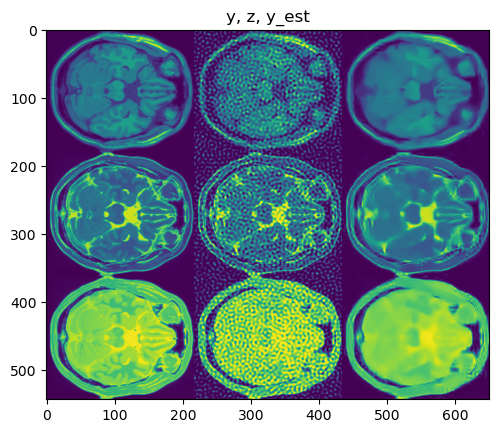

In [11]:
main()

PSNR: 30.2619261573305
PSNR cropped: 30.06572164122192


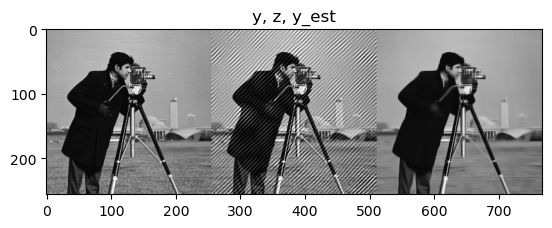

In [9]:
# Experiment specifications
imagename = 'cameraman256.png'

# Load noise-free image
y = np.array(Image.open(imagename)) / 255
# Possible noise types to be generated 'gw', 'g1', 'g2', 'g3', 'g4', 'g1w',
# 'g2w', 'g3w', 'g4w'.
noise_type = 'g3'
noise_var = 0.02  # Noise variance
seed = 0  # seed for pseudorandom noise realization

# Generate noise with given PSD
noise, psd, kernel = get_experiment_noise(noise_type, noise_var, seed, y.shape)
# N.B.: For the sake of simulating a more realistic acquisition scenario,
# the generated noise is *not* circulant. Therefore there is a slight
# discrepancy between PSD and the actual PSD computed from infinitely many
# realizations of this noise with different seeds.

# Generate noisy image corrupted by additive spatially correlated noise
# with noise power spectrum PSD
z = np.atleast_3d(y) + np.atleast_3d(noise)

# Call BM3D With the default settings.
y_est = bm3d(z, psd)

# To include refiltering:
# y_est = bm3d(z, psd, 'refilter')

# For other settings, use BM3DProfile.
# profile = BM3DProfile(); # equivalent to profile = BM3DProfile('np');
# profile.gamma = 6;  # redefine value of gamma parameter
# y_est = bm3d(z, psd, profile);

# Note: For white noise, you may instead of the PSD
# also pass a standard deviation
# y_est = bm3d(z, sqrt(noise_var));

psnr = get_psnr(y, y_est)
print("PSNR:", psnr)

# PSNR ignoring 16-pixel wide borders (as used in the paper), due to refiltering potentially leaving artifacts
# on the pixels near the boundary of the image when noise is not circulant
psnr_cropped = get_cropped_psnr(y, y_est, [16, 16])
print("PSNR cropped:", psnr_cropped)

# Ignore values outside range for display (or plt gives an error for multichannel input)
y_est = np.minimum(np.maximum(y_est, 0), 1)
z_rang = np.minimum(np.maximum(z, 0), 1)
plt.title("y, z, y_est")
plt.imshow(np.concatenate((y, np.squeeze(z_rang), y_est), axis=1), cmap='gray')
plt.show()

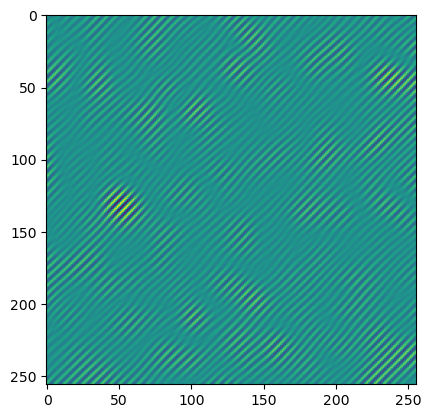

In [18]:
plt.imshow(noise)

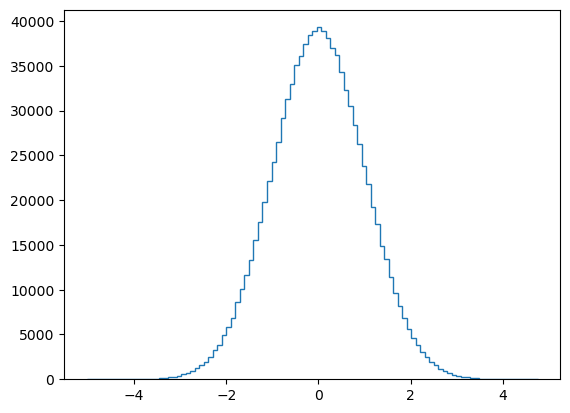

In [35]:
plt.hist((np.fft.ifft2(np.fft.fft2(np.random.randn(1000, 1000)) * np.sqrt(np.ones((1000,1000)))).real.flatten()), bins=100, histtype='step') 
plt.show()

In [13]:
def compute_autocovariance(im):
    """Compute autocovariance of an image.

    Args:
        im: Image.

    Returns:
        autocovariance: Autocovariance of image.
    """
    # Compute autocovariance of image
    autocovariance = np.fft.ifft2(np.abs(np.fft.fft2(im)) ** 2).real
    return autocovariance

def compute_psd(im):
    """Compute power spectral density (PSD) of an image.

    Args:
        im: Image.

    Returns:
        psd: PSD of image.
    """
    # Compute PSD by averaging over all channels of the image
    psd = np.mean(np.abs(np.fft.fftshift(np.fft.fft2(im, axes=(0, 1))), 0) ** 2, 2)
    return psd


In [ ]:
from dataHandler.dataset import MHDProjDataset, LogNormalTransform

dataset = MHDProjDataset(root_dir=SOURCE_DIR, transform=LogNormalTransform())

In [14]:
# Experiment specifications

# The multichannel example data is acquired from: http://www.bic.mni.mcgill.ca/brainweb/
# (C.A. Cocosco, V. Kollokian, R.K.-S. Kwan, A.C. Evans,
#  "BrainWeb: Online Interface to a 3D MRI Simulated Brain Database"
# NeuroImage, vol.5, no.4, part 2/4, S425, 1997
# -- Proceedings of 3rd International Conference on Functional Mapping of the Human Brain, Copenhagen, May 1997.
data_name = 'examples/brainslice.mat'
table_name = 'slice_sample'

# Load noise-free image
# Data should be in same shape as with Image.open, but channel count can be any (M x N x channels)
# Noise-free data should be between 0 and 1.
y = loadmat(data_name)[table_name]
# Possible noise types to be generated 'gw', 'g1', 'g2', 'g3', 'g4', 'g1w',
# 'g2w', 'g3w', 'g4w'.
noise_type = 'g2'
noise_var = 0.02  # Noise variance
seed = 0  # seed for pseudorandom noise realization

# Generate noise with given PSD
noise, psd, kernel = get_experiment_noise(noise_type, noise_var, seed, y.shape)

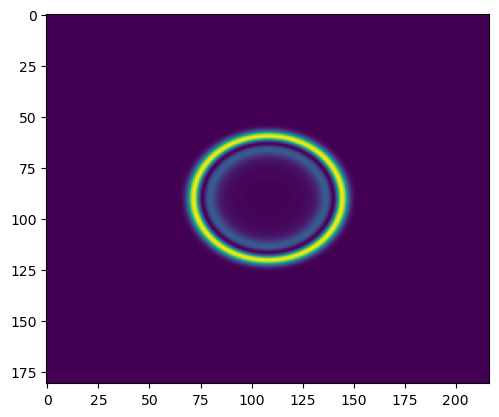

In [9]:
plt.imshow(np.fft.fftshift(psd))

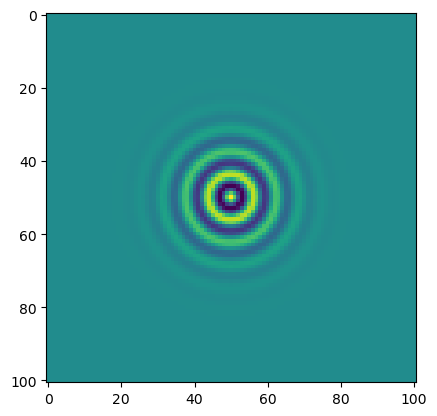

In [10]:
plt.imshow(kernel)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


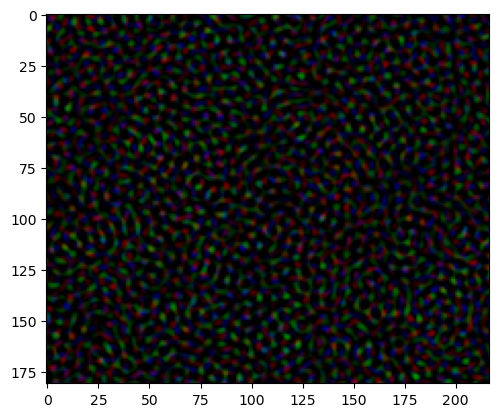

In [11]:
plt.imshow(noise)

In [12]:
# Experiment specifications
imagename = 'image_Lena512rgb.png'

# Load noise-free image
y = np.array(Image.open(imagename)) / 255

# Possible noise types to be generated 'gw', 'g1', 'g2', 'g3', 'g4', 'g1w',
# 'g2w', 'g3w', 'g4w'.
noise_type = 'g3'
noise_var = 0.02  # Noise variance
seed = 0  # seed for pseudorandom noise realization

# Generate noise with given PSD
noise, psd, kernel = get_experiment_noise(noise_type, noise_var, seed, y.shape)